# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# As a first step I will download boston dataset from sklearn to get the description
from sklearn.datasets import load_boston
boston_descr = load_boston()
print(boston_descr.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Import and explore the data. Clean the data for outliers and missing values. 

In [3]:
# Read csv file from data folder
# Check if it has been properly loaded with df.head()
boston = pd.read_csv('../data/boston_data.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [4]:
# General overview of the dataset with df.info()
# No missing values
# All columns are numeric
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     404 non-null    float64
 1   zn       404 non-null    float64
 2   indus    404 non-null    float64
 3   chas     404 non-null    float64
 4   nox      404 non-null    float64
 5   rm       404 non-null    float64
 6   age      404 non-null    float64
 7   dis      404 non-null    float64
 8   rad      404 non-null    float64
 9   tax      404 non-null    float64
 10  ptratio  404 non-null    float64
 11  black    404 non-null    float64
 12  lstat    404 non-null    float64
 13  medv     404 non-null    float64
dtypes: float64(14)
memory usage: 44.2 KB


In [5]:
# General overview of the distribution of each numerical column with df.describe()
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

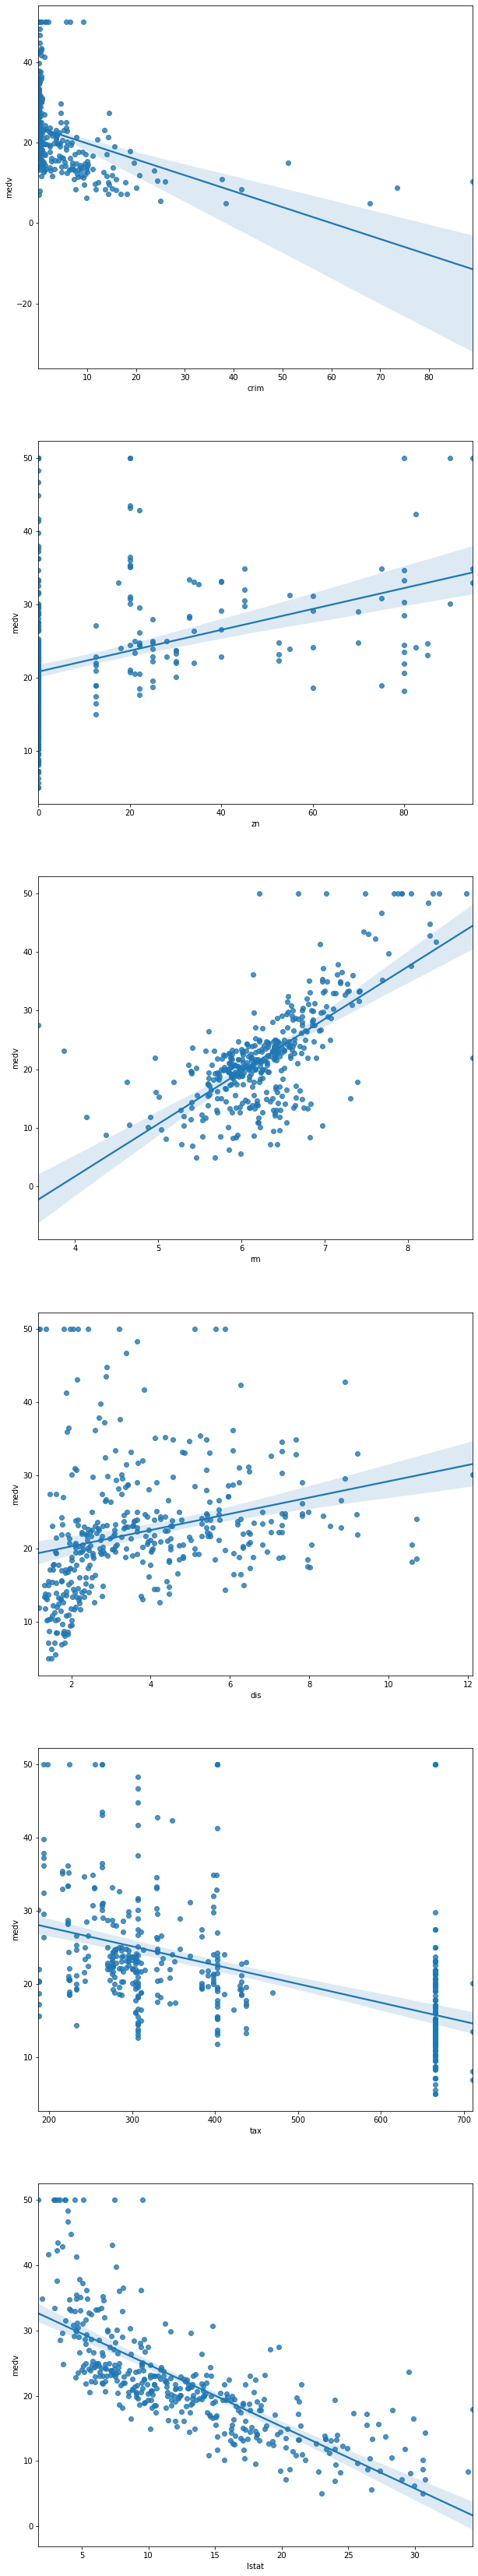

In [6]:
# Create a list with the variables I think can be correlated with prices
variables_list = ['crim', 'zn', 'rm', 'dis', 'tax', 'lstat']

# Generate a regplot between the variables of the list and medv to check correlations
fig, ax = plt.subplots(6 ,figsize=(10,60))
for i,j in enumerate(variables_list):
    sns.regplot(data=boston, y='medv', x=j, ax=ax[i])

# CRIM     per capita crime rate by town - small negative correlation
# ZN       proportion of residential land zoned for lots over 25,000 sq.ft. - small positive correlation
# RM       average number of rooms per dwelling - strong positive correlation
# DIS      weighted distances to five Boston employment centres - small psoitive correlation
# TAX      full-value property-tax rate per $10,000 - small negative correlation
# LSTAT    % lower status of the population - strong negative correlation

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

<AxesSubplot:>

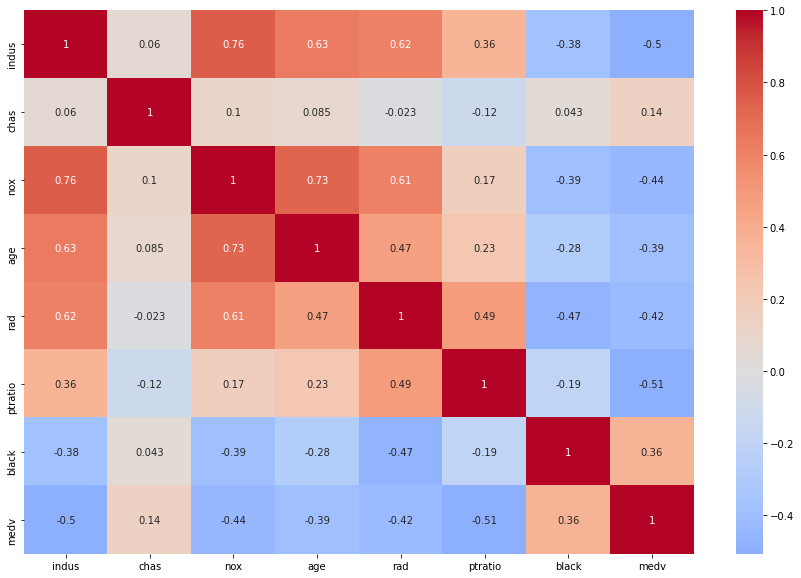

In [7]:
# Generate a heatmap from correlation table of variables not in variable_list
fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(boston.drop(variables_list, axis=1).corr(), center=0, cmap='coolwarm', annot=True)

# INDUS    proportion of non-retail business acres per town - negative correlation
# CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) - small positive correlation
# NOX      nitric oxides concentration (parts per 10 million) - negative correlation
# AGE      proportion of owner-occupied units built prior to 1940 - negative correlation
# RAD      index of accessibility to radial highways - negative correlation
# PTRATIO  pupil-teacher ratio by town - negative correlation
# B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town - positive correlation


### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [8]:
# General overview of the distribution of columns 'medv' with  df.describe()
boston['medv'].describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

In [9]:
# Conclusions
# The distribution seems quite normal
# Positive skew (more observations in lower mean side and longer tail in the right side, median lower than mean)

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [10]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_pred)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [11]:
# First of all, let's define dependent and independent variables
X = boston.drop('medv', axis = 1)
y = boston['medv']

In [12]:
# Import method train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the dataset, shuffle parameter is standardly set as True
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Check the shape of the splitted X to check if it has been properly done
X_train.shape

(323, 13)

In [14]:
X_test.shape

(81, 13)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [15]:
# Import RandomeForest method from sklearn
from sklearn.ensemble import RandomForestRegressor

In [16]:
# Model 2: max_depth = 2
model2 = RandomForestRegressor(max_depth=2)

# Model 4: max_depth = 4
model4 = RandomForestRegressor(max_depth=4)

# Model 6: max_depth = 6
model6 = RandomForestRegressor(max_depth=6)

# Model 8: max_depth = 8
model8 = RandomForestRegressor(max_depth=8)

# Model 10: max_depth = 10
model10 = RandomForestRegressor(max_depth=10)

Now, plot the score for each tree on the training set and on the testing set.

[Text(0.5, 1.0, 'TEST SPLIT')]

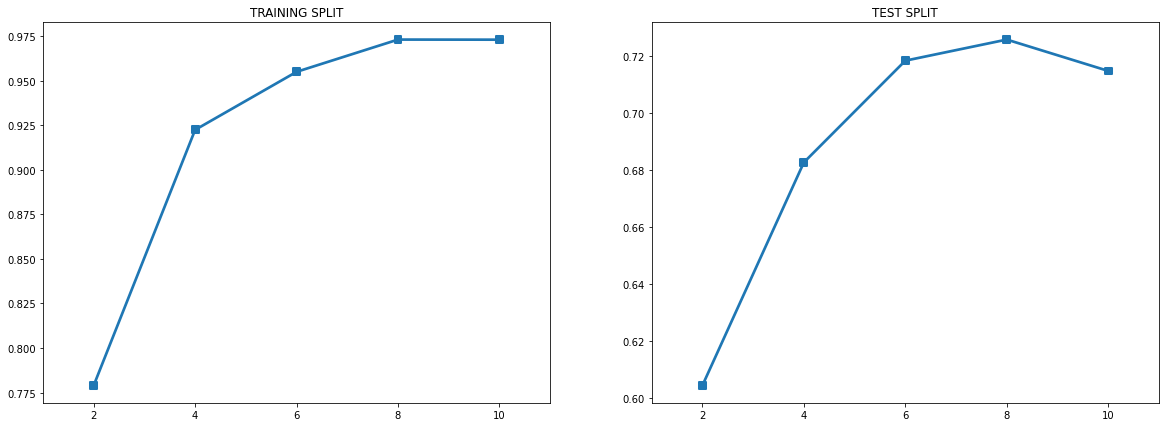

In [17]:
# Produce a plot with the score for the TRAINING and TEST splits for the different max depths
fig, ax = plt.subplots(1, 2,figsize=(20,7))
sns.pointplot(x = np.arange(2,11,2), y = [model2.fit(X_train, y_train).score(X_train, y_train),
        model4.fit(X_train, y_train).score(X_train, y_train),
        model6.fit(X_train, y_train).score(X_train, y_train),
        model8.fit(X_train, y_train).score(X_train, y_train),
        model10.fit(X_train, y_train).score(X_train, y_train)], markers='s', ax=ax[0]).set(title='TRAINING SPLIT')

sns.pointplot(x = np.arange(2,11,2), y = [model2.fit(X_train, y_train).score(X_test, y_test),
        model4.fit(X_train, y_train).score(X_test, y_test),
        model6.fit(X_train, y_train).score(X_test, y_test),
        model8.fit(X_train, y_train).score(X_test, y_test),
        model10.fit(X_train, y_train).score(X_test, y_test)], markers='s', ax=ax[1]).set(title='TEST SPLIT')

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [18]:
# From the graph we can assume that the positive effect in the score when increasing the depth decreases as we add new levels
# It ends up not having positive effects in scoring despite of adding more levels of depth

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [19]:
# Import croos_val_score from sklearn
from sklearn.model_selection import cross_val_score

In [20]:
# Model 1: max_depth = 1
model1 = RandomForestRegressor(max_depth=1).fit(X_train, y_train)

# Score for X_train and X_test
np.mean(cross_val_score(model1,X_train, y_train)), np.mean(cross_val_score(model1,X_test, y_test))

(0.5161220770032771, 0.373474499175929)

In [21]:
# Model 10: max_depth = 10
model10 = RandomForestRegressor(max_depth=10).fit(X_train, y_train)

# Score for X_train and X_test
np.mean(cross_val_score(model10,X_train, y_train)), np.mean(cross_val_score(model10,X_test, y_test))

(0.8423992311880669, 0.5897719167878636)

In [22]:
# By checking the cross_val_score for max_depth = 1 and max_depth=10 we ccan see the following facts:
# Max_depth = 1: higher bias (both scores are lower) but lower variance (difference between train scoring and test scoring is lower)
# Max_depth = 10: lower bias (both scores are higher) but higher variance (difference between train scoring and test scoring is lower)

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [23]:
# Make some parameter tunning
# Import library GridSearchCV from sklearn
from sklearn.model_selection import GridSearchCV

In [24]:
# Define params as the number of max_depth
params = {'max_depth': np.arange(2, 11, 2)}

In [25]:
# Max_depth = 8 would have the highest score
# Besides, it would probably have lower variance than max_depth=10
grid = GridSearchCV(RandomForestRegressor(), params, cv=10)
grid.fit(X_train, y_train)
grid.best_estimator_

RandomForestRegressor(max_depth=8)

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [26]:
# I consider this model would not be applicable at all
# The scoring is far from being a good predictor - model is not robust enough
# Current relevant elements to determine the price of a house have nothing to with 1978. Moreover, it can eb that the same feature could have opposite effects on price that it used to have in 1979